![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 10 -  Object Detection </center>
### <center> Mean Average Precision (mAP) </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_ObjectDetection/MainMAP.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/10_ObjectDetection/DeepLearningFramework ./DeepLearningFramework
    !pip install torchinfo

In [4]:
#-----------------------------------------------------------#
#-----------------------------------------------------------#
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn    as nn
import torch.optim as optim
import torchinfo

from torch.optim.lr_scheduler import OneCycleLR
#-----------------------------------------------------------#
#-----------------------------------------------------------#
torch.set_printoptions(3, linewidth=120, sci_mode=False)
torch.backends.cudnn.benchmark = True

#### Constants:

In [5]:
IMAGE_SIZE = 100
GRID_SIZE  = 5
LABELS     = ['R', 'G', 'B']
NUM_LABELS = len(LABELS)

DEVICE     = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### `RandImage` creates a synthetic image for object detection:

In [6]:
from DeepLearningFramework.AnchorsUtils import RandImage

mI, mBBox = RandImage(IMAGE_SIZE, 3)
mBBox

tensor([[1.000, 0.000, 0.670, 0.361, 0.544, 0.535],
        [1.000, 2.000, 0.866, 0.711, 0.234, 0.219],
        [1.000, 1.000, 0.147, 0.901, 0.294, 0.198]])

#### Plot an image with its bounding boxes:

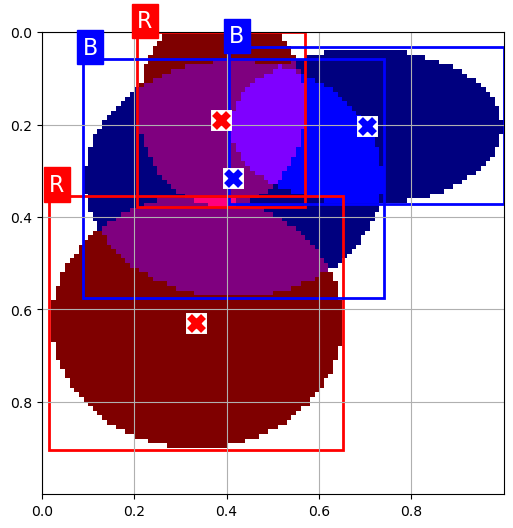

In [7]:
from DeepLearningFramework.AnchorsUtils import PlotImage

nObjects  = np.random.randint(10) + 1
mI, mBBox = RandImage(IMAGE_SIZE, nObjects)

PlotImage(mI, mBBox, LABELS, lColors=np.eye(3), gridSize=GRID_SIZE)
plt.show ()

#### Create synthetic datasets:
Note that `mBBox.shape = (Di, 6)` where `Di` is the number of objects.  
`Di` is different from image to image.

In [8]:
def MakeData(N):
    mX    = torch.empty(N, 3, IMAGE_SIZE, IMAGE_SIZE)
    lBBox = [None] * N
    for ii in range(N):
        nObjects   = np.random.randint(4) + 1
        mXi, mBBox = RandImage(IMAGE_SIZE, nObjects)
        mX   [ii]  = mXi
        lBBox[ii]  = mBBox

    return mX, lBBox
        
nTrain = 10000
nTest  = 1000

mTrainX, lTrainBBox = MakeData(nTrain)
mTestX,  lTestBBox  = MakeData(nTest)

mTrainX.shape, len(lTrainBBox)

(torch.Size([10000, 3, 100, 100]), 10000)

### Anchors:
`mAnchors.shape = (B, 2)`

In [9]:
mAnchors = torch.tensor([[0.30, 0.50],
                         [0.50, 0.30]])

B        = mAnchors.shape[0]

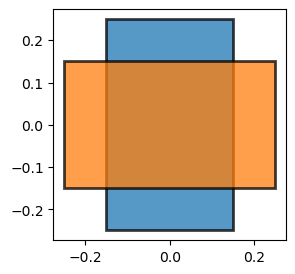

In [10]:
import matplotlib
from   matplotlib.patches import Rectangle
#-----------------------------------------------------------------------------------------------------#
#-----------------------------------------------------------------------------------------------------#
_, ax = plt.subplots(figsize=(3, 3))

cmap = matplotlib.cm.get_cmap('tab10')
for ii in range(B):
    W, H  = mAnchors[ii,:]
    oBBox = Rectangle((-W/2, -H/2), W, H, linewidth=2, edgecolor='k', facecolor=cmap(ii), alpha=.75)
    ax.add_patch(oBBox)

ax.axis('equal')
plt.show()

#### Create train and test sets:

In [11]:
from DeepLearningFramework.AnchorsUtils import AnchorObjectDataset

oTrainSet = AnchorObjectDataset(mTrainX, lTrainBBox, mAnchors, GRID_SIZE)
oTestSet  = AnchorObjectDataset(mTestX,  lTestBBox,  mAnchors, GRID_SIZE)

len(oTrainSet), len(oTestSet)

(10000, 1000)

#### Data-loader:

In [12]:
from DeepLearningFramework.Dataset import AnchorObjectCollate

batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=AnchorObjectCollate, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=AnchorObjectCollate, num_workers=2, persistent_workers=True)

mX,       lBBox,      mTarget = next(iter(oTrainDL))
mX.shape, len(lBBox), mTarget.shape

(torch.Size([256, 3, 100, 100]), 256, torch.Size([256, 2, 6, 5, 5]))

### Define the model:
The output shape is: $B \times (5+L) \times S \times S$.  
In our case $B = 2$, $S = 5$, and $L = 3$.  
($L$ is the number of labels)

To make sure $x, y \in [0, 1]$ we use a `sigmoid`.

In [13]:
class ResBlock(nn.Module):
    def __init__(self, C):
        super().__init__()

        self.oLeftBranch = nn.Sequential(
            nn.Conv2d(C, C//2, 1, stride=1, padding=0, bias=False), nn.BatchNorm2d(C//2), nn.LeakyReLU(0.1),
            nn.Conv2d(C//2, C, 3, stride=1, padding=1, bias=False), nn.BatchNorm2d(C   ), nn.LeakyReLU(0.1),
        )
        
    def forward(self, mX):
        mOut = self.oLeftBranch(mX) + mX
        return mOut

In [14]:
class Model(nn.Module):
    def __init__(self, B):
        super(Model, self).__init__()

        self.B  = B
        self.oNN = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(3,   32,  5, stride=2, padding=2, bias=False), nn.BatchNorm2d(32 ), nn.ReLU(), nn.Dropout2d(0.1),
            ResBlock(32),                                                                            nn.Dropout2d(0.1),
            ResBlock(32),                                                                            nn.Dropout2d(0.1),
            nn.Conv2d(32,  64,  3, stride=2, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(), nn.Dropout2d(0.1),
            ResBlock(64),                                                                            nn.Dropout2d(0.1),
            ResBlock(64),                                                                            nn.Dropout2d(0.1),
            nn.Conv2d(64,  128, 3, stride=2, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.1),
            ResBlock(128),                                                                           nn.Dropout2d(0.1),
            ResBlock(128),                                                                           nn.Dropout2d(0.1),
            nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.1),
            ResBlock(256),                                                                           nn.Dropout2d(0.1),
            ResBlock(256),                                                                           nn.Dropout2d(0.1),
            nn.Conv2d(256, 512, 3, stride=2, padding=2, bias=False), nn.BatchNorm2d(512), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(512, B*8, 1, stride=1, padding=0, bias=True ),
    )
        
    def forward(self, mX):
        mOutput = self.oNN(mX)                                 #-- [N, B*8, S, S]
        mOutput = mOutput.view(-1, B, 8, GRID_SIZE, GRID_SIZE) #-- [N, B, 8, S, S]
        
                                        #-- mOutput[ii,bb,:,jj,kk] = [p | x, y, log(W), log(H) | R, G, B]
        mOutput[:,:,1:3,:,:].sigmoid_() #-- makes sure x and y are in [0, 1]
                
        return mOutput
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#
#-- Model summary:
mTarget = Model(B)(mX)
mTarget.shape, \
torchinfo.summary(Model(B), mX.shape)

(torch.Size([256, 2, 8, 5, 5]),
 Layer (type:depth-idx)                   Output Shape              Param #
 Model                                    --                        --
 ├─Sequential: 1-1                        [256, 16, 5, 5]           --
 │    └─Identity: 2-1                     [256, 3, 100, 100]        --
 │    └─Conv2d: 2-2                       [256, 32, 50, 50]         2,400
 │    └─BatchNorm2d: 2-3                  [256, 32, 50, 50]         64
 │    └─ReLU: 2-4                         [256, 32, 50, 50]         --
 │    └─Dropout2d: 2-5                    [256, 32, 50, 50]         --
 │    └─ResBlock: 2-6                     [256, 32, 50, 50]         --
 │    │    └─Sequential: 3-1              [256, 32, 50, 50]         5,216
 │    └─Dropout2d: 2-7                    [256, 32, 50, 50]         --
 │    └─ResBlock: 2-8                     [256, 32, 50, 50]         --
 │    │    └─Sequential: 3-2              [256, 32, 50, 50]         5,216
 │    └─Dropout2d: 2-9         

#### `CatWithIndex` is the same as `torch.cat` only it returns the original index of each example.
The code is very ugly but very fast.  
(Let me know if you can do it faster)

In [15]:
def CatWithIndex(lX):
    vLen         = torch.tensor([mX.shape[0] for mX in lX])
    vPos         = torch.cumsum(vLen, dim=0)
    L            = vPos[-1] #-- vLen.sum()
    vDelta       = torch.zeros(L + 1)
    vDelta[vPos] = 1
    vIdxZero     = torch.where(vLen == 0)
    for idx in vIdxZero:
        vDelta[vPos[idx]] += 1

    vIdx = torch.cumsum(vDelta[:-1], dim=0)
    mX   = torch.cat   (lX)

    return mX, vIdx

In [16]:
# def CatWithIndex(lX):
    
#     lIdx = []
#     for ii, X in enumerate(lX):
#         lIdx += [ii * torch.ones(X.shape[0])]
    
#     vIdx = torch.cat(lIdx)
#     mX   = torch.cat(lX)

#     return mX, vIdx

#### Compute the table for the mAP:

In [17]:
import torchvision.ops as ops

def ComputeTable(lNMS, lBBox, nLabels):
    #-- len(lNMS)      = N1
    #-- len(lBBox)     = N2
    #-- lNMS[ii].shape = (Di, 6)
    #-- lNMS[ii][jj,:] = [prob | cIdx | x, y, W, H]
    #-- Same for lBBox
    
    if len(lNMS) == 0:
        return torch.empty(0, 3, device=DEVICE)
    
    mBBox, vImageIdx  = CatWithIndex(lBBox) #-- (N2, 6)
    mNMS,  vImageIdx2 = CatWithIndex(lNMS ) #-- (N1, 6)

    mBBox      = mBBox     .to(DEVICE)
    mNMS       = mNMS      .to(DEVICE)
    vImageIdx  = vImageIdx .to(DEVICE)
    vImageIdx2 = vImageIdx2.to(DEVICE)

    mIoU = ops.box_iou(                                  #-- mIoU.shape = (N1, N2)
        ops.box_convert(mNMS [:,2:], 'cxcywh', 'xyxy'),
        ops.box_convert(mBBox[:,2:], 'cxcywh', 'xyxy')
    )
    
    mImageMask  = vImageIdx2[:,None] == vImageIdx[None,:]
    mLabelMask  = mNMS[:,[1]]        == mBBox[:,[1]].T
    mIoU       *= mImageMask & mLabelMask & (mIoU > 0.5) #-- (N1, N2)

    vMax, vIdx          = torch.max  (mIoU, dim=0)
    vTP                 = torch.zeros(mNMS.shape[0], device=DEVICE) #-- N1
    vTP[vIdx[vMax > 0]] = 1
    
    mTable      = torch.cat([mNMS[:,:2], vTP[:,None]], dim=1)           #-- (N1, 3)
    v           = torch.arange(nLabels, device=DEVICE)
    vLabelCount = (mBBox[:,[1]] == v[None,:]).sum(0)
    
    return mTable, vLabelCount

#### Compute mAP:

In [18]:
def ComputeMAP(mTable, vLabelCount):
    vIdx    = torch.argsort(mTable[:,0], descending=True)
    mTable  = mTable[vIdx]
    nLabels = vLabelCount.shape[0]
        
    lAP = []
    for cc in range(nLabels):
#         if vLabelCount[cc] == 0:
#             continue

        vIdx  = mTable[:,1] == cc
        vTPc  = mTable[vIdx,2]
        nBBox = vTPc.shape[0]

        vPrecision     = torch.ones (nBBox + 1, device=DEVICE)
        vRecall        = torch.zeros(nBBox + 1, device=DEVICE)
        vCumsumTP      = torch.cumsum(vTPc, dim=0)
        vPrecision[1:] = vCumsumTP / torch.arange(1, nBBox+1, device=DEVICE)
        vRecall   [1:] = vCumsumTP / vLabelCount[cc]
        AP             = torch.trapz(vPrecision, vRecall)
        lAP += [AP]
        
    mAP = torch.tensor(lAP).mean().item()
    
    return mAP

In [19]:
from DeepLearningFramework.AnchorsUtils import Output2Target, Target2BBox, NMS

def Metric(mOut, lBBox):
    mTargetPred    = Output2Target(mOut)
    mBBoxPred      = Target2BBox  (mTargetPred, GRID_SIZE)
    lNMS           = NMS(mBBoxPred)
    mTable, vCount = ComputeTable(lNMS, lBBox, NUM_LABELS)
    
    return mTable, vCount

### `Epoch`
* Compute the table for each batch.
* Compute the mAP for the entire dataset (in the end of the epoch).

In [20]:
def Epoch(oModel, oDataDL, Loss, oOptim=None, oScheduler=None, bTrain=True):

    vEpochStats = np.zeros(5) #-- (Loss, BCE, CE, MSE, Metric)
    count       = 0
    nIter       = len(oDataDL)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test
    
    lTable = []
    vCount = 0
    
    #-- Iterate over the mini-batches:
    for ii, (mX, lBBox, mTarget) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX      = mX     .to(DEVICE)
        mTarget = mTarget.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mOut               = oModel(mX)
            loss, BCE, CE, MSE = Loss  (mOut, mTarget)

            #-- Backward:
            oOptim    .zero_grad() #-- set gradients to zeros
            loss      .backward () #-- backward
            oOptim    .step     () #-- update parameters
            oScheduler.step     () #-- update learning rate
            
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mOut               = oModel(mX)
                loss, BCE, CE, MSE = Loss  (mOut, mTarget)        

        with torch.no_grad():
            mTable_, vCount_  = Metric(mOut, lBBox)
            lTable           += [mTable_]
            vCount           += vCount_
                        
            Nb                = mX.shape[0]
            vIterStats        = np.array([loss.item(), BCE, CE, MSE, -loss.item()])
            vEpochStats      += Nb * vIterStats
            count            += Nb
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    vEpochStats     /= count
    epochMAP         = ComputeMAP(torch.cat(lTable), vCount)
    vEpochStats[-1]  = epochMAP
    
    return vEpochStats

In [21]:
import time

def TrainModel(oModel, oTrainData, oValData, Loss, Metric, nEpochs, oOptim, oScheduler=None, sModelName='MAP'):

    TRAIN        = 0
    VAL          = 1
    vLR          = np.full(0,       np.nan)
    mHistory     = np.full((2, 5, nEpochs), np.nan)
    lNames       = ['Loss', 'BCE', 'CE', 'MSE', 'Metric']
    bestMetric   = -float('inf')

    fig, _ = plt.subplots(2, 3, figsize=(12, 6))
    for epoch in range(nEpochs):
        startTime               = time.time()
        mHistory[TRAIN,:,epoch] = Epoch(oModel, oTrainData, Loss, oOptim, oScheduler, bTrain=True ) #-- train
        mHistory[VAL,  :,epoch] = Epoch(oModel, oValData,   Loss,                     bTrain=False) #-- validate
        epochTime               = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '            f'{epoch                   :03d}:',   end='')
        print(' | Train loss: '   f'{mHistory[TRAIN,0,epoch] :6.3f}',   end='')
        print(' | Val loss: '     f'{mHistory[VAL,  0,epoch] :6.3f}',   end='')
        print(' | Train Metric: ' f'{mHistory[TRAIN,4,epoch] :6.3f}',   end='')
        print(' | Val Metric: '   f'{mHistory[VAL,  4,epoch] :6.3f}',   end='')
        print(' | epoch time: '   f'{epochTime               :6.3f} |', end='')

        valMetric = mHistory[VAL,4,epoch]
        #-- Save best model (early stopping):
        if valMetric > bestMetric:
            bestMetric = valMetric
            try   : torch.save(oModel.state_dict(), sModelName + '.pt')
            except: pass
            print(' <-- Checkpoint!')
        else:
            print('')
            
        for ii, ax in enumerate(fig.axes):
            if ii == 5: continue
            ax.cla      ()
            ax.plot     (mHistory[TRAIN, ii], 'b', label='Train')
            ax.plot     (mHistory[VAL,   ii], 'r', label='Validation')
            ax.set_title(lNames[ii])
            ax.grid     ()
            ax.legend   ()

        fig.canvas.draw ()
        plt.tight_layout()
        plt.pause       (1e-4)

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load(sModelName + '.pt'))

    return mHistory

<IPython.core.display.Javascript object>


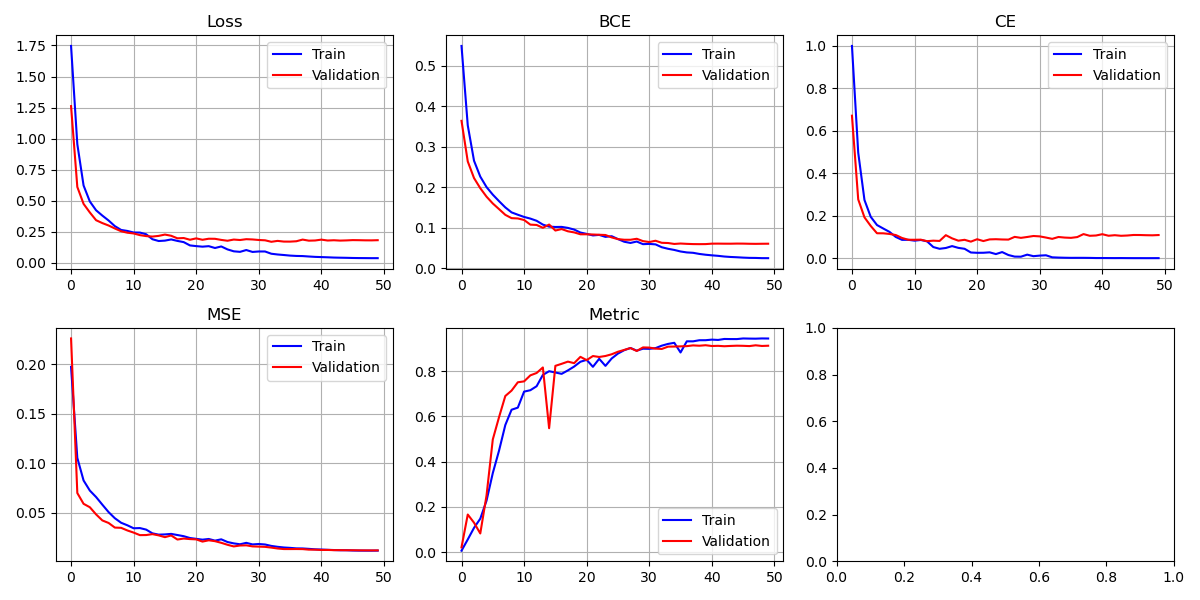

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  1.746 | Val loss:  1.262 | Train Metric:  0.006 | Val Metric:  0.021 | epoch time: 12.431 | <-- Checkpoint!
Epoch 001: | Train loss:  0.956 | Val loss:  0.611 | Train Metric:  0.056 | Val Metric:  0.166 | epoch time:  6.884 | <-- Checkpoint!
Epoch 002: | Train loss:  0.623 | Val loss:  0.475 | Train Metric:  0.107 | Val Metric:  0.130 | epoch time:  6.797 |
Epoch 003: | Train loss:  0.494 | Val loss:  0.406 | Train Metric:  0.148 | Val Metric:  0.082 | epoch time:  6.732 |
Epoch 004: | Train loss:  0.423 | Val loss:  0.343 | Train Metric:  0.227 | Val Metric:  0.250 | epoch time:  6.799 | <-- Checkpoint!
Epoch 005: | Train loss:  0.380 | Val loss:  0.320 | Train Metric:  0.349 | Val Metric:  0.498 | epoch time:  6.847 | <-- Checkpoint!
Epoch 006: | Train loss:  0.341 | Val loss:  0.300 | Train Metric:  0.449 | Val Metric:  0.596 | epoch time

In [22]:
%matplotlib notebook

from DeepLearningFramework.ObjectDetectionUtils import Loss

nEpochs    = 50
nIter      = nEpochs * len(oTrainDL)

oModel     = Model      (B).to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=4e-3)
oScheduler = OneCycleLR (oOptim, max_lr=2e-3, total_steps=nIter)
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler)

In [23]:
#-- Load best model (early stopping):
# oModel.load_state_dict(torch.load('./MAP_v1.pt'))
# oModel.train(False);

#### Test model:

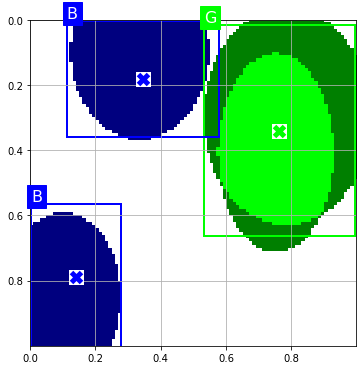

In [24]:
%matplotlib inline

mXi, mBBox, mTarget = oTestSet[np.random.randint(nTest)]
with torch.no_grad():
    mOutput = oModel(mXi[None].to(DEVICE))

mTargetPred = Output2Target(mOutput)
mBBoxPred   = Target2BBox  (mTargetPred, GRID_SIZE)
mNMS        = NMS(mBBoxPred)[0]

PlotImage(mXi, mNMS, vLabels=LABELS, lColors=np.eye(3), gridSize=GRID_SIZE)
plt.show ()

#### Test two objects in the same cell:

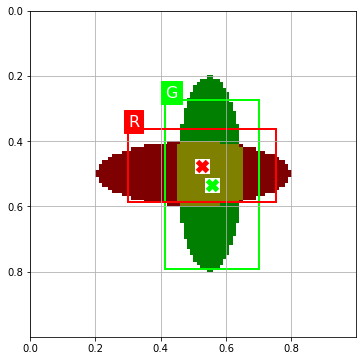

In [25]:
from DeepLearningFramework.AnchorsUtils import CreateImage

mXi, mBBox = CreateImage(IMAGE_SIZE, np.array([.5, .55]), [.5, .5], [.3, .1], [.1, .3], [0, 1])

with torch.no_grad():
    mOutput = oModel(mXi[None].to(DEVICE))

mTargetPred = Output2Target(mOutput)
mBBoxPred   = Target2BBox  (mTargetPred, GRID_SIZE).cpu()[0]
vIdx        = mBBoxPred[:,0] > 0.3

PlotImage(mXi, mBBoxPred[vIdx], vLabels=LABELS, lColors=np.eye(3))
plt.show ()